# LGBM Model
* RNN was far too slow and hence infeasible given the time limit I am constrained within
* So going to use an LGBM

# Misc / setting up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import datetime
from IPython.display import display
from pprint import pprint
import lightgbm as lgbm
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold
import time
from sklearn import preprocessing

In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\psydm7\Anaconda3\envs\mle_tf

In [2]:
import random
SEED = 137
random.seed(SEED)

In [3]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# loading the data

In [4]:
df_train = pd.read_pickle("../Data/Prepared_Data/supervised/consumption_all.pkl")
display(df_train)
df_preds = pd.read_pickle("../Data/Prepared_Data/supervised/consumption_all_preds.pkl")
display(df_preds)

,meter_id,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,meter_id_8,...,semi_detached,terraced,energy n-7,energy n-6,energy n-5,energy n-4,energy n-3,energy n-2,energy n-1,meter_reading
0,0x240e5e22734a44a174b7dabcf1ea00d70d9ec168,0,0,0,0,0,0,0,0,0,...,1.0,0.0,11.805677,11.942665,11.552484,12.231637,12.903379,12.511848,12.101536,11.881495
1,0x2ce3d582a1316db5bcfe405cbd6070268944778e,0,0,0,0,0,0,0,0,0,...,1.0,0.0,11.805677,11.942665,11.552484,12.231637,12.903379,12.511848,12.101536,11.881495
2,0x306e6baa9367d3c43fa6ecc2d0054b207d6ef471,0,0,0,0,0,0,0,0,0,...,1.0,0.0,11.805677,11.942665,11.552484,12.231637,12.903379,12.511848,12.101536,11.881495
3,0x391e6c2169c27de797ccbdf2d623365da28a6d3d,0,0,0,0,0,0,0,0,0,...,1.0,0.0,11.805677,11.942665,11.552484,12.231637,12.903379,12.511848,12.101536,11.881495
4,0x423fa805ddb0cba9bdb4460f9a78540287eefd0e,0,0,0,0,0,0,0,0,0,...,1.0,0.0,11.805677,11.942665,11.552484,12.231637,12.903379,12.511848,12.101536,11.881495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617640,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.0,0.0,21.999000,26.232000,14.036000,15.990000,15.550500,15.111000,16.506000,18.758500
617641,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.0,0.0,26.232000,14.036000,15.990000,15.550500,15.111000,16.506000,18.758500,21.011000
617642,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.0,0.0,14.036000,15.990000,15.550500,15.111000,16.506000,18.758500,21.011000,19.204000
617643,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.0,0.0,15.990000,15.550500,15.111000,16.506000,18.758500,21.011000,19.204000,17.397000


,meter_id,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,meter_id_8,...,semi_detached,terraced,energy n-7,energy n-6,energy n-5,energy n-4,energy n-3,energy n-2,energy n-1,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185515,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1185516,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1185517,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1185518,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# formatting the df's

In [5]:
#replacing nans with 0 so we can aggregate up the OOF predictions
df_preds["meter_reading"] = df_preds["meter_reading"].fillna(0) 
#dropping the "energy n-k" columns as they are needed for 3D RNN input not 2D LGBM input
df_preds = df_preds.drop(["energy n-7","energy n-6","energy n-5","energy n-4","energy n-3","energy n-2","energy n-1"], axis=1)
df_train = df_train.drop(["energy n-7","energy n-6","energy n-5","energy n-4","energy n-3","energy n-2","energy n-1"], axis=1)

display(df_train)
display(df_preds)

,meter_id,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,meter_id_8,...,month_cos,is_weekend,energy_cluster,num_bedrooms,dwelling_type,detached,flat,semi_detached,terraced,meter_reading
0,0x240e5e22734a44a174b7dabcf1ea00d70d9ec168,0,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
1,0x2ce3d582a1316db5bcfe405cbd6070268944778e,0,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
2,0x306e6baa9367d3c43fa6ecc2d0054b207d6ef471,0,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
3,0x391e6c2169c27de797ccbdf2d623365da28a6d3d,0,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
4,0x423fa805ddb0cba9bdb4460f9a78540287eefd0e,0,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617640,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,18.758500
617641,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,21.011000
617642,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,19.204000
617643,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,1,1,3.0,detached_house,1.0,0.0,0.0,0.0,17.397000


,meter_id,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,meter_id_8,...,month_cos,is_weekend,energy_cluster,num_bedrooms,dwelling_type,detached,flat,semi_detached,terraced,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185515,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185516,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185517,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,1,1,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185518,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,1,1,3.0,detached_house,1.0,0.0,0.0,0.0,0


# Ordinally encoding the ID's
* One hot / binary encoding can actually worsen performance of DT based algorithms
* and LGBM supports categorical values; so no need to use the binary encoded meter_id which we planned for the RNN
* Hence I will also now encode the ID ordinally and experiment with both to see which gives the best performing results

In [6]:
#removing the binary encoded ID's as LGBM supports categorical values hence we can just use ordinal encoded ID's for better performance
#commented out for random search as will experiment with using both
# binary_encoded_cols=[]
# for i in range(13):
#     binary_encoded_cols.append(f"meter_id_{i}")
# df_train=df_train.drop(binary_encoded_cols,axis=1)
# df_preds=df_preds.drop(binary_encoded_cols,axis=1)

In [7]:
#ordinally encoding id's
le = preprocessing.LabelEncoder()
le.fit(df_train["meter_id"])

#ordinally encoding with same encoder so will encode the same
df_train.insert(1, "meter_id_ord", le.transform(df_train["meter_id"]))
df_preds.insert(1, "meter_id_ord", le.transform(df_preds["meter_id"]))

display(df_train)
display(df_preds)

,meter_id,meter_id_ord,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,...,month_cos,is_weekend,energy_cluster,num_bedrooms,dwelling_type,detached,flat,semi_detached,terraced,meter_reading
0,0x240e5e22734a44a174b7dabcf1ea00d70d9ec168,425,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
1,0x2ce3d582a1316db5bcfe405cbd6070268944778e,542,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
2,0x306e6baa9367d3c43fa6ecc2d0054b207d6ef471,585,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
3,0x391e6c2169c27de797ccbdf2d623365da28a6d3d,688,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
4,0x423fa805ddb0cba9bdb4460f9a78540287eefd0e,793,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617640,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,18.758500
617641,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,21.011000
617642,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,19.204000
617643,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,1,1,3.0,detached_house,1.0,0.0,0.0,0.0,17.397000


,meter_id,meter_id_ord,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,...,month_cos,is_weekend,energy_cluster,num_bedrooms,dwelling_type,detached,flat,semi_detached,terraced,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185515,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185516,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185517,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,1,1,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185518,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,1,1,3.0,detached_house,1.0,0.0,0.0,0.0,0


# Ordinally encoding the dwelling_type
* same reasons for replacing the binary encoded meter_id with ordinal encoding; going to replace one hot encodede dwelling type with ordinal encoding

In [8]:
#removing the binary encoded ID's as LGBM supports categorical values hence we can just use ordinal encoded ID's for better performance
# not dropping the orginal random search will experiment with ordinal and onehot
# onehot_encoded_cols = ["detached","flat","terraced","semi_detached"]
# df_train=df_train.drop(onehot_encoded_cols,axis=1)
# df_preds=df_preds.drop(onehot_encoded_cols,axis=1)

In [9]:
#ordinally encoding dwelling_type
le = preprocessing.LabelEncoder()
le.fit(df_train["dwelling_type"])

#ordinally encoding with same encoder so will encode the same
df_train.insert(27, "dwelling_type_ord", le.transform(df_train["dwelling_type"]))
df_preds.insert(27, "dwelling_type_ord", le.transform(df_preds["dwelling_type"]))

display(df_train)
display(df_preds)

,meter_id,meter_id_ord,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,...,is_weekend,energy_cluster,num_bedrooms,dwelling_type,dwelling_type_ord,detached,flat,semi_detached,terraced,meter_reading
0,0x240e5e22734a44a174b7dabcf1ea00d70d9ec168,425,0,0,0,0,0,0,0,0,...,1,0,3.0,semi_detached_house,3,0.0,0.0,1.0,0.0,11.881495
1,0x2ce3d582a1316db5bcfe405cbd6070268944778e,542,0,0,0,0,0,0,0,0,...,1,0,3.0,semi_detached_house,3,0.0,0.0,1.0,0.0,11.881495
2,0x306e6baa9367d3c43fa6ecc2d0054b207d6ef471,585,0,0,0,0,0,0,0,0,...,1,0,3.0,semi_detached_house,3,0.0,0.0,1.0,0.0,11.881495
3,0x391e6c2169c27de797ccbdf2d623365da28a6d3d,688,0,0,0,0,0,0,0,0,...,1,0,3.0,semi_detached_house,3,0.0,0.0,1.0,0.0,11.881495
4,0x423fa805ddb0cba9bdb4460f9a78540287eefd0e,793,0,0,0,0,0,0,0,0,...,1,0,3.0,semi_detached_house,3,0.0,0.0,1.0,0.0,11.881495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617640,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0,1,3.0,detached_house,1,1.0,0.0,0.0,0.0,18.758500
617641,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0,1,3.0,detached_house,1,1.0,0.0,0.0,0.0,21.011000
617642,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0,1,3.0,detached_house,1,1.0,0.0,0.0,0.0,19.204000
617643,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,1,1,3.0,detached_house,1,1.0,0.0,0.0,0.0,17.397000


,meter_id,meter_id_ord,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,...,is_weekend,energy_cluster,num_bedrooms,dwelling_type,dwelling_type_ord,detached,flat,semi_detached,terraced,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,0
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,0
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,0
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,0
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185515,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0,1,3.0,detached_house,1,1.0,0.0,0.0,0.0,0
1185516,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0,1,3.0,detached_house,1,1.0,0.0,0.0,0.0,0
1185517,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,1,1,3.0,detached_house,1,1.0,0.0,0.0,0.0,0
1185518,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,1,1,3.0,detached_house,1,1.0,0.0,0.0,0.0,0


# SKF-CV for training the LGBM
* Using skf on df_train by meter_id with 3 folds
    * Meaning for each iteration we use 2/3 of each meters data for training and 1/3 of each meters data for validating
* using out of fold predictions, making predictions on each fold and aggregating them together for the final prediction

* evaluates the model via OOF predictions made on the held out set on each fold
* this score is returned and along with the 3 models
* random search will then be used to find the LGBM hyper param config with the best val score and this will then be used to make predictions using the model which has the best validation score

In [11]:
import warnings
warnings.filterwarnings("ignore")

#function for running the cross fold
    #args:
        #disp_fold_info = True if we want to print info for each fold
        #disp_end_info = True if we want to display evaluation info at the end
        #SEED = random seed used for fair repeatability
        #num_folds = number of folds in skf (pretty certain going to keep this at 3 )
        #df_train = training dataframe
        #y_col = the name of the label we want to predict (meter_reading)
        #X_cols = the name of the feature columns we are using
        #X_cat = the name of these features which are categorical
        #params = hyper params for the LGBM model
    #returns:
        #time_of_execution = how long it took to train the model on all folds; will be used as a point of comparison
        #valid_score = MAE calculated using the Out-of-Fold Predictions on the df_train, used for hyper-param tuning
        #lgbm_models = array of the different lgbm_models
        
def run_lgbm_skf_cv(disp_fold_info, disp_end_info, SEED, num_folds, df_train, y_col, X_cols, X_cat, params):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state = SEED) # defining the SKF algorithm

    lgbm_models = []
    start_time = time.time()
    fold_iter=1
    #running the startified kfold, splitting df_train by meter_id, so we use 2/3 of each meters reading for training
    for train_index, valid_index in skf.split(df_train, df_train["meter_id"]):

        print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Fold {fold_iter}{color.END}")
        
        #splitting into the features and labels for the train and valid folds
        X_train, X_valid = df_train.loc[train_index, X_cols], df_train.loc[valid_index, X_cols]
        y_train, y_valid = df_train.loc[train_index, y_col], df_train.loc[valid_index, y_col]
        
        if(disp_fold_info):
            print(f"{color.CYAN}{color.UNDERLINE}X_train{color.END}")
            display(X_train.head(5))
            print(f"{color.CYAN}{color.UNDERLINE}y_train{color.END}")
            display(y_train.head(5))
            print(f"{color.CYAN}{color.UNDERLINE}X_valid{color.END}")
            display(X_valid.head(5))
            print(f"{color.CYAN}{color.UNDERLINE}y_valid{color.END}")
            display(y_valid.head(5))
            
        print(f"{color.CYAN}{color.UNDERLINE}Training the LGBM{color.END}")
        #instantiating a lgbm regressor with our params
        lgbm_model = lgbm.LGBMRegressor(**params)
        #fitting the lgbm model on the 2/3 train and evaluating on the 1/3 valid
        #printing details every 1000 iters + stopping if no improvement made in 250 iters
        lgbm_model.fit(X_train, y_train,
                       eval_set=[(X_valid, y_valid)],
                       categorical_feature=X_cat,
                       verbose=1000,
                       early_stopping_rounds=250)
        
        #saving the OOF prediction for the held out rows (valid rows from df_train) from the lgbm model with the best performing intrinisic parmams 
        oof_valid = lgbm_model.predict(X_valid, num_iteration=lgbm_model.best_iteration_) # making prediction on the held out rows, X_valid
        df_train.loc[valid_index, "oof"] = oof_valid #storing the oof rows 
        if(disp_fold_info):
            print(f"{color.CYAN}{color.UNDERLINE}df_train OOF predictions{color.END}")
            display(df_train.loc[valid_index, ["meter_id","oof"]].head(5))
               
        #appending this lgbm
        lgbm_models.append(lgbm_model)
        if(disp_fold_info):
            print(f"{color.CYAN}{color.UNDERLINE}lgbm_models size{color.END}: {len(lgbm_models)}")
            
        fold_iter+=1
        
    if(disp_end_info):
        print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}training set OOF preds vs true{color.END}")
        display(df_train[["meter_id","date","meter_reading","oof"]])
        print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for skf-cv:  {color.END}{str(datetime.timedelta(seconds=round(LGBM_TOE)))}\n")
        print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {LGBM_MAE}\n")
    
    #calculating execution time and the MAE on the training set
    time_of_execution = time.time() - start_time
    valid_score=mean_absolute_error(df_train[y_col], df_train["oof"]) 
    
    
    return (time_of_execution, valid_score, lgbm_models)


# Running random search on the LGBM skf-cv function
* going to run random search to find the hyper param config which gav the best MAE on OOF predictions on the train ste in skf-cv
    * originally implemented grid search in an earlier commit but it was incredibly slow due to the exponential growth from the wide range of hyper paramaeters
        * decided to use random search has it has been proven to be more efficient than grid search in research eg in the paper" Random search for hyper-parameter optimization" (James bergstra et al. 2012 Montreal)


In [12]:
y_col = "meter_reading" #we want to predict the meter_reading (this will always be the same)

## Setting the column types and grouping ones together that should be grouped
* Not specifying configurations anymore letting random search pick them itself

In [16]:
df_train.columns

Index(['meter_id', 'meter_id_ord', 'meter_id_0', 'meter_id_1', 'meter_id_2',
       'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7',
       'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12',
       'date', 'day_of_year_sin', 'day_of_year_cos', 'day_of_week',
       'day_of_month', 'month_ord', 'month_sin', 'month_cos', 'is_weekend',
       'energy_cluster', 'num_bedrooms', 'dwelling_type', 'dwelling_type_ord',
       'detached', 'flat', 'semi_detached', 'terraced', 'meter_reading'],
      dtype='object')

In [41]:
#dictionary to hold all groups of columns which could be chosen
#done as if we just pick columns completely random we may get just "meter_id_3" from the binary encoded meter_id's
#wouldn't make any sense without the other respective binary encoded meter_id columns

possible_columns = {}
possible_columns["meter_id_ord"] = ["meter_id_ord"]
possible_columns["meter_id_binary"] = ['meter_id_0', 'meter_id_1', 'meter_id_2',
       'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7',
       'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12']
possible_columns["day_of_year_cyclic"] = ["day_of_year_sin","day_of_year_cos"]
possible_columns["day_of_week"] = ["day_of_week"]
possible_columns["day_of_month"] = ["day_of_month"]
possible_columns["month_ord"] = ["month_ord"]
possible_columns["month_cyclic"] = ["month_sin","month_cos"]
possible_columns["is_weekend"] = ["is_weekend"]
possible_columns["energy_cluster"] = ["energy_cluster"]
possible_columns["num_bedrooms"] = ["num_bedrooms"]
possible_columns["dwelling_type_ord"] = ["dwelling_type_ord"]
possible_columns["dwelling_type_onehot"] = ['detached', 'flat', 'semi_detached', 'terraced']
pprint(possible_columns)

{'day_of_month': ['day_of_month'],
 'day_of_week': ['day_of_week'],
 'day_of_year_cyclic': ['day_of_year_sin', 'day_of_year_cos'],
 'dwelling_type_onehot': ['detached', 'flat', 'semi_detached', 'terraced'],
 'dwelling_type_ord': ['dwelling_type_ord'],
 'energy_cluster': ['energy_cluster'],
 'is_weekend': ['is_weekend'],
 'meter_id_binary': ['meter_id_0',
                     'meter_id_1',
                     'meter_id_2',
                     'meter_id_3',
                     'meter_id_4',
                     'meter_id_5',
                     'meter_id_6',
                     'meter_id_7',
                     'meter_id_8',
                     'meter_id_9',
                     'meter_id_10',
                     'meter_id_11',
                     'meter_id_12'],
 'meter_id_ord': ['meter_id_ord'],
 'month_cyclic': ['month_sin', 'month_cos'],
 'month_ord': ['month_ord'],
 'num_bedrooms': ['num_bedrooms']}


In [26]:
# setting categorical columns

all_cat = ["meter_id_ord", 'meter_id_0', 'meter_id_1', 'meter_id_2',
           'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7',
           'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12',
           "day_of_week", "day_of_month", "month_ord", "is_weekend", "energy_cluster",
           "dwelling_type_ord", "detached", "flat", "semi_detached", "terraced"] #all categorical values

# setting categorical columns in the dataframe to be categorical
#X_cat[0] holds all columns (besides clusters but we aren't using that) 
for i in all_cat:
    df_train[i] = df_train[i].astype('category')
    df_preds[i] = df_preds[i].astype('category')

### Defining the model parameters for random search
* sensible different combinations of params for the model

* default values which make sense and the others have place holders as they will be found in random search

In [52]:
#default params (including ones we will override and those we won't)
params = {
    ### won't be tuned ###
    'boosting_type': 'gbdt', #gbdt/rf/dart/goss
    'metric': 'mae', 
    'num_threads': -1, # number of threads to run on for speed (auto)
    'num_iterations': 10000, #defining the models runs
    'seed': SEED, # all runs with same seed for better comparison between different hyper params
    
    
    ### will be tuned (replace these with the best performing) ###
    'learning_rate': 0.99999,
    'num_leaves': 99999, # limit max numer of leaves in a tree
    "max_depth":99999, # limit max depth of the tree to prevent overfitting
    # fraction to be bagged/sampled every k iterations
    'bagging_fraction': 0.99999,
    'bagging_freq' : 99999,
    'feature_fraction': 0.99999, # fraction of features to use at each tree node
    #l1 & l2 regularization to prevent overfitting
    "lambda_l1": 99999,
    "lambda_l2": 99999
}

pprint(params)

{'bagging_fraction': 0.99999,
 'bagging_freq': 99999,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.99999,
 'lambda_l1': 99999,
 'lambda_l2': 99999,
 'learning_rate': 0.99999,
 'max_depth': 99999,
 'metric': 'mae',
 'num_iterations': 100,
 'num_leaves': 99999,
 'num_threads': -1,
 'seed': 137}


## Running the random search
* grid search is now outdated only here for the sake of research; will make a separate cleaned notebook at the end with only the relevant code

In [53]:
num_folds = 3 # 3 fold skf; so we use 2/3 of each meters readings for training at each iteration 
i=0 #just used to print the index of each skf-cv run
all_results = [] # will hold array of all the tuples of results + hyper params

#random search
print(f"{color.BOLD}Running random search hyper parameter optimization{color.END}\n")
start_time = time.time()
#going to test n hyper parameter configurations
n=10
for i in tqdm(range(n)):
    print(f"{color.BOLD}{color.RED}{color.UNDERLINE}skf-cv LGBM run {i}{color.END}")
    #### randomly generate the hyper parameters for this model within a sensible range for each ####

    #firstly randomly picking the features we will use
    print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Picking random features{color.END}")
    X_cols = []#this will store the X_cols we use

    #generating probability of accepting each column
    prob_to_beat = random.randrange(30,100)/100 #between 0.3 and 1
    #iterating through each column and randomly decide whether or not to pick it
    for key in possible_columns.keys():
        #randomly generate a decimal for this column group
        this_prob = random.randrange(0,100)/100 #between 0 and 1
        #if this is less than the probability to beat then accept it
        if(this_prob<prob_to_beat):
            print(key,this_prob,"<=",prob_to_beat)
            X_cols+=(possible_columns[key])
    print(X_cols)
    
    this_X_cats = list(set(X_cols).intersection(all_cat)) #getting the categorical values for this X
    
    #then get LGBM hyper parameters
    this_params = params.copy()
    this_params["learning_rate"] = random.randrange(10,25)/1000 #between 0.01 and 0.025
    this_params["max_depth"] = random.randrange(6,12)
    this_params["num_leaves"] = random.randrange(np.round(2**(this_params["max_depth"])*0.5), np.round(2**(this_params["max_depth"])*0.9)) #picking a random max leaves less than 2^(max_depth) to prevent over fitting (between 50 and 90%)
    this_params["bagging_fraction"] = random.randrange(65,90)/100 #between 0.65 and 0.9
    this_params["bagging_freq"] = random.randrange(5,25)
    this_params["feature_fraction"] = random.randrange(65,90)/100 #between 0.65 and 0.9
    this_params["lambda_l1"] = random.randrange(8,18)
    this_params["lambda_l2"] = random.randrange(4,14)

    #train the model with this hyper param config and store it's results

    pprint(this_params)
    all_results.append((run_lgbm_skf_cv(False, False, SEED, num_folds, df_train.copy(), y_col, X_cols, this_X_cats, this_params),(X_cols,this_params)))
    print("\n\n\n")
time_of_execution = time.time()-start_time
print(f"{color.BOLD}Random search ran {n} iterations in {str(datetime.timedelta(seconds=round(time_of_execution)))}{color.END}\n")

Running random search hyper parameter optimization



  0%|          | 0/10 [00:00<?, ?it/s]

skf-cv LGBM run 0
Picking random features
meter_id_ord 0.19 <= 0.93
meter_id_binary 0.87 <= 0.93
day_of_year_cyclic 0.69 <= 0.93
day_of_week 0.41 <= 0.93
day_of_month 0.22 <= 0.93
month_ord 0.08 <= 0.93
month_cyclic 0.84 <= 0.93
is_weekend 0.48 <= 0.93
energy_cluster 0.34 <= 0.93
num_bedrooms 0.87 <= 0.93
dwelling_type_ord 0.84 <= 0.93
dwelling_type_onehot 0.67 <= 0.93
['meter_id_ord', 'meter_id_0', 'meter_id_1', 'meter_id_2', 'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7', 'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12', 'day_of_year_sin', 'day_of_year_cos', 'day_of_week', 'day_of_month', 'month_ord', 'month_sin', 'month_cos', 'is_weekend', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord', 'detached', 'flat', 'semi_detached', 'terraced']
{'bagging_fraction': 0.79,
 'bagging_freq': 9,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.88,
 'lambda_l1': 10,
 'lambda_l2': 9,
 'learning_rate': 0.022,
 'max_depth': 7,
 'metric': 'mae',
 'num

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 2.97612
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.84, subsample=1.0 will be ignored. Current value: bagging_fraction=0.84
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=24, subsample_freq=0 will be ignored. Current value: bagging_freq=24
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 2.96666
Fold 3
Training the LGBM
[LightGBM] [Warning

Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.76, subsample=1.0 will be ignored. Current value: bagging_fraction=0.76
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
[LightGBM] [Warning] bagging_freq is set=19, subsample_freq=0 will be ignored. Current value: bagging_freq=19
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 2.62856




skf-cv LGBM run 5
Picking random features
meter_id_ord 0.25 <= 0.35
meter_id_binary 0.32 <= 0.35
month_ord 0.33 <= 0.35
['meter_id_ord', 'meter_id_0', 'meter_id_1', 'meter_id_2',

Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.73, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.73
[LightGBM] [Warning] lambda_l1 is set=9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9
[LightGBM] [Warning] bagging_fraction is set=0.87, subsample=1.0 will be ignored. Current value: bagging_fraction=0.87
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=9, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 2.43884
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.73, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.73
[LightGBM] [Warning] lambda_l1 is set=

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 2.4999
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.76, subsample=1.0 will be ignored. Current value: bagging_fraction=0.76
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8
[LightGBM] [Warning] bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 2.51555




Random search ran 10 iterations in 0:03

## Visualising information from the random search results
### Box plots of the MAE for the different columns

In [70]:
columns_maes = {} #dictionary of each columns maes
if "test" not in columns_maes:
    columns_maes["test"]=[]
columns_maes["test"].append("1")
columns_maes

{'test': ['1']}

  0%|          | 0/12 [00:00<?, ?it/s]

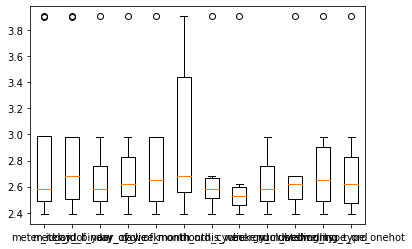

In [75]:
columns_maes = {} #dictionary of each columns maes
#iterating through each column and randomly decide whether or not to pick it
for key in tqdm(possible_columns.keys()):
    column = possible_columns[key][0] # only want to check against one column for the 'in'
    #iterating through every single models results
    for i in range(len(all_results)):
        #if this column was used by the model
        if column in all_results[i][1][0]:
            # if this column doesn't yet exist in the dict, create it
            if key not in columns_maes:
                columns_maes[key]=[]
            # adding this models mae to the dict entry for this column
            columns_maes[key].append(all_results[i][0][1])

# print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}MAEs for each model which contains columns of eaach type{color.END}")
# pprint(columns_maes)

#plotting a boxplot of these
labels, data = columns_maes.keys(), columns_maes.values()
plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels,figsize=(10,1))
plt.show()

In [54]:
#inspecting the min/max/mean of time of execution of the models we tested in grid search
all_toes = []
all_maes = [] 

for i in range(len(all_results)):
    #getting the results for this model
    all_toes.append(all_results[i][0][0])
    all_maes.append(all_results[i][0][1])
    
print()
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}min time of execution = {color.END}{str(datetime.timedelta(seconds=round(min(all_toes))))}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}max time of execution = {color.END}{str(datetime.timedelta(seconds=round(max(all_toes))))}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}mean time of execution = {color.END}{str(datetime.timedelta(seconds=round(np.mean(all_toes))))}")
print()
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}min MAE = {color.END}{min(all_maes)}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}max MAE= {color.END}{max(all_maes)}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}mean MAE = {color.END}{np.mean(all_maes)}")


min time of execution = 0:00:16
max time of execution = 0:00:34
mean time of execution = 0:00:23

min MAE = 2.390520394078271
max MAE= 3.9039371647411807
mean MAE = 2.8945681764053885


## Inspecting the results of the hyper parameter optimization

In [55]:
best_index = 0
best_mae = 999999

for i in range(len(all_results)):
    #getting the results for this model
    LGBM_TOE = all_results[i][0][0]
    LGBM_MAE = all_results[i][0][1]
    #displaying the results
    print(f"{color.BOLD}{color.RED}{color.UNDERLINE}skf-cv run {i}{color.END}")
    print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for skf-cv:{color.END} {str(datetime.timedelta(seconds=round(LGBM_TOE)))}")
    print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {LGBM_MAE}")
    print("")
    
    #keeping track of the best performing model
    if(LGBM_MAE<best_mae):
        best_mae=LGBM_MAE
        best_index = i
print("best model is at index",best_index,"with a MAE of",best_mae)

skf-cv run 0
Time of execution for skf-cv: 0:00:25
Mean absolute error between OOF preds and meter_reading on training set: 2.390520394078271

skf-cv run 1
Time of execution for skf-cv: 0:00:34
Mean absolute error between OOF preds and meter_reading on training set: 2.6835840808897644

skf-cv run 2
Time of execution for skf-cv: 0:00:22
Mean absolute error between OOF preds and meter_reading on training set: 2.977405676059044

skf-cv run 3
Time of execution for skf-cv: 0:00:22
Mean absolute error between OOF preds and meter_reading on training set: 3.9039371647411807

skf-cv run 4
Time of execution for skf-cv: 0:00:21
Mean absolute error between OOF preds and meter_reading on training set: 2.61851393480558

skf-cv run 5
Time of execution for skf-cv: 0:00:23
Mean absolute error between OOF preds and meter_reading on training set: 3.897061926809749

skf-cv run 6
Time of execution for skf-cv: 0:00:18
Mean absolute error between OOF preds and meter_reading on training set: 2.547717577173391

## Making predictions on best model

In [56]:
#making predictions based on the best performing model and displaying it's information
BEST_LGBM_MODELS = all_results[best_index][0][2] #getting the lgbm_models from the best index
BEST_LGBM_FORECASTS = df_preds.copy()
start_time = time.time() 

#calculating the average preds by summing the weighted preds for each folds model
for i in range(len(BEST_LGBM_MODELS)):
    pred_forecasts = BEST_LGBM_MODELS[i].predict(BEST_LGBM_FORECASTS[all_results[best_index][1][0]], num_iteration=BEST_LGBM_MODELS[i].best_iteration_) #predicting the unkown df_preds
    BEST_LGBM_FORECASTS[y_col] += pred_forecasts / num_folds #weighting the predictions for BEST_LGBM_FORECASTS for this fold and adding to df_preds y column 
BEST_LGBM_FORECASTS["meter_reading"] = BEST_LGBM_FORECASTS.meter_reading.clip(lower=0) #clip meter_reading so no predictions lower than 0
execution_time = time.time() - start_time

## Inspecting information on best model

In [57]:
#printing the forecasts and other evaluation info
print(f"{color.BOLD}{color.RED}{color.UNDERLINE}best model came from skf-cv run {best_index}{color.END}")
#displaying the results
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Evaluation and results{color.END}")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for skf-cv:  {color.END}{str(datetime.timedelta(seconds=round(all_results[best_index][0][0])))}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for predictions: {color.END}{str(datetime.timedelta(seconds=round(execution_time)))}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Total time of execution: {color.END}{str(datetime.timedelta(seconds=round(all_results[best_index][0][0]+execution_time)))}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {all_results[best_index][0][1]}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}preds set with the next years forecasts for each meter{color.END}")
display(BEST_LGBM_FORECASTS[["meter_id","date","meter_reading"]])
#displaying the hyperparameters
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Hyper-parameters{color.END}")
print(f"\n{color.BOLD}{color.CYAN}{color.UNDERLINE}X_cols:{color.END}\n")
pprint(all_results[best_index][1][0])
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}model params:  {color.END}")
pprint(all_results[best_index][1][1])

best model came from skf-cv run 0
Evaluation and results
Time of execution for skf-cv:  0:00:25

Time of execution for predictions: 0:00:23

Total time of execution: 0:00:48

Mean absolute error between OOF preds and meter_reading on training set: 2.390520394078271

preds set with the next years forecasts for each meter


,meter_id,date,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2018-01-01,5.582890
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2018-01-02,5.606248
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2018-01-03,5.583359
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2018-01-04,5.595403
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2018-01-05,5.582890
...,...,...,...
1185515,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2018-12-27,20.511321
1185516,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2018-12-28,21.213426
1185517,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2018-12-29,21.336408
1185518,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2018-12-30,20.764697


Hyper-parameters

X_cols:

['meter_id_ord',
 'meter_id_0',
 'meter_id_1',
 'meter_id_2',
 'meter_id_3',
 'meter_id_4',
 'meter_id_5',
 'meter_id_6',
 'meter_id_7',
 'meter_id_8',
 'meter_id_9',
 'meter_id_10',
 'meter_id_11',
 'meter_id_12',
 'day_of_year_sin',
 'day_of_year_cos',
 'day_of_week',
 'day_of_month',
 'month_ord',
 'month_sin',
 'month_cos',
 'is_weekend',
 'energy_cluster',
 'num_bedrooms',
 'dwelling_type_ord',
 'detached',
 'flat',
 'semi_detached',
 'terraced']
model params:  
{'bagging_fraction': 0.79,
 'bagging_freq': 9,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.88,
 'lambda_l1': 10,
 'lambda_l2': 9,
 'learning_rate': 0.022,
 'max_depth': 7,
 'metric': 'mae',
 'num_iterations': 100,
 'num_leaves': 108,
 'num_threads': -1,
 'seed': 137}


# Converting into monthly forecasts ready for submission

# Plotting these monthly forecasts